# Library Install

This code installs three packages using the conda package manager: pdfplumber, pymupdf, and pillow. These packages are used for working with PDF files in Python.

1) The first package, pdfplumber, is a library that provides an easy-to-use interface for extracting data from PDFs. It allows you to read the contents of a PDF file as if it were a text file, and it also includes functions for searching and manipulating the contents of a PDF.

2) The second package, pymupdf, is a library that provides a more low-level interface for working with PDF files. It allows you to manipulate the structure of a PDF document, including adding or removing pages, and it also includes functions for extracting data from specific parts of a PDF file.

3) The third package, pillow, is a library that provides an easy-to-use interface for working with images in Python. It allows you to read and write image files, as well as perform various operations on them, such as resizing or cropping.

Overall, these packages provide a powerful set of tools for working with PDFs and images in Python, and they can be used together to automate a wide range of tasks related to data extraction and manipulation.


# PDF Ingestion Playground (Spiral 0 — Component A)
_Generated 2025-10-06 02:09_

This notebook helps you prototype PDF ingestion:
1) Load a PDF and gather metadata
2) Render page images at a chosen DPI (via **PyMuPDF / `fitz`**)
3) Extract text/layout spans (via **pdfplumber**)

It also includes inline **assertion tests** to mimic unit tests before moving to `pytest`.

> Tip: Place one or more real PDFs in a `data/` folder next to this notebook, e.g., `data/sample.pdf`.

## 0) Environment check
Quick imports + version print. If something fails, ensure your `eqscribe` environment is active and includes `pymupdf`, `pdfplumber`, and `pillow`.

In [7]:
# # === Annotated for learning ===

# # Import sys/platform for environment diagnostics
# import sys, platform
# print(f'Python: {sys.version.split()[0]}  |  Platform: {platform.platform()}')

# try:
# # Import PyMuPDF (as fitz), for rendering pages and PDF geometry operations
#     import fitz  # PyMuPDF
#     print('PyMuPDF (fitz):', getattr(fitz, '__doc__', '').splitlines()[0])
# # Error handling: catch unexpected errors (e.g., scanned PDFs without text) to avoid crashing
# except Exception as e:
#     print('PyMuPDF import error:', e)

# try:
# # Import pdfplumber, used for extracting text and layout spans from PDFs
#     import pdfplumber
#     print('pdfplumber:', getattr(pdfplumber, "__version__", "unknown"))
# # Error handling: catch unexpected errors (e.g., scanned PDFs without text) to avoid crashing
# except Exception as e:
#     print('pdfplumber import error:', e)

# try:
# # Import Pillow (PIL), Python Imaging Library fork for image handling
#     from PIL import Image
#     print('Pillow (PIL): OK')
# # Error handling: catch unexpected errors (e.g., scanned PDFs without text) to avoid crashing
# except Exception as e:
#     print('Pillow import error:', e)

%load_ext autoreload
%autoreload 2

from equation_scribe.pdf_ingest import load_pdf,page_layout,page_size_points,page_image,pdf_to_px_transform
from equation_scribe.validate import validate_latex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Utilities & Data Classes
We define a small `PdfDoc` class and utility functions for loading, rendering, and layout extraction.
- **Coordinate notes:** PDF coordinates are in points (1/72 inch), origin at bottom-left; image pixels origin is top-left. We store helpers to convert between systems when needed.

In [8]:
# # === Annotated for learning ===

# from __future__ import annotations
# # Import dataclass to define lightweight classes with auto-generated methods
# from dataclasses import dataclass
# # Import Path for easier filesystem path handling
# from pathlib import Path
# # Import typing utilities for type hints in function signatures
# from typing import List, Tuple, Dict, Any, Optional

# # Import PyMuPDF (as fitz), for rendering pages and PDF geometry operations
# import fitz  # PyMuPDF
# # Import pdfplumber, used for extracting text and layout spans from PDFs
# import pdfplumber
# # Import Pillow (PIL), Python Imaging Library fork for image handling
# from PIL import Image

# PT_PER_INCH = 72.0

# # Import dataclass to define lightweight classes with auto-generated methods
# @dataclass
# # PdfDoc: small container class for PDF state (path, num_pages, default dpi)
# class PdfDoc:
#     """
#     PdfDoc: simple data container for PDF info.
#     Attributes:
#         path (Path): filesystem path to the PDF file.
#         num_pages (int): number of pages in the PDF.
#         dpi (int): default resolution for rendering (dots per inch).
#     """
#     path: Path
#     num_pages: int
#     dpi: int = 300

# # load_pdf: open a PDF, count pages, ensure file exists/non-empty, return PdfDoc
# # Inputs: file path, dpi. Output: PdfDoc object.
# def load_pdf(path: str | Path, dpi: int = 300) -> PdfDoc:
#     """
#     load_pdf(path, dpi): Open a PDF, count pages, and ensure it exists/non-empty.
#     Args:
#         path (str or Path): Path to the PDF file.
#         dpi (int): resolution for rendering, default 300.
#     Returns:
#         PdfDoc: a PdfDoc object with path, num_pages, and dpi.
#     Raises:
#         FileNotFoundError: if file does not exist.
#         ValueError: if PDF has zero pages.
#     """
#     path = Path(path)
# # Error check: raise FileNotFoundError if the PDF path does not exist
#     if not path.exists():
#         raise FileNotFoundError(f'PDF not found: {path}')
#     with pdfplumber.open(str(path)) as pdf:
#         num_pages = len(pdf.pages)
# # Error check: raise ValueError if PDF has no pages
#         if num_pages == 0:
#             raise ValueError('PDF has zero pages')
#     return PdfDoc(path=path, num_pages=num_pages, dpi=dpi)

# # page_size_points: return width and height of a page in PDF points (units = 1/72 inch)
# def page_size_points(doc: PdfDoc, i: int) -> Tuple[float, float]:
#     """
#     page_size_points(doc, i): Get width and height of a page in PDF points.
#     Args:
#         doc (PdfDoc): PDF document object.
#         i (int): page index (0-based).
#     Returns:
#         (float, float): width and height of the page in points.
#     """
#     with fitz.open(str(doc.path)) as pdf:
#         page = pdf[i]
#         rect = page.rect  # in points
#         return float(rect.width), float(rect.height)

# # page_image: render a page to an RGB Pillow image at specified dpi
# # Inputs: PdfDoc, page index, optional dpi. Output: Pillow Image
# def page_image(doc: PdfDoc, i: int, dpi: Optional[int]=None) -> Image.Image:
#     """
#     page_image(doc, i, dpi): Render a page to a Pillow image.
#     Args:
#         doc (PdfDoc): PDF document object.
#         i (int): page index (0-based).
#         dpi (int, optional): override dpi, default from doc.
#     Returns:
#         PIL.Image.Image: rendered RGB image of the page.
#     Raises:
#         AssertionError: if page index is invalid.
#     """
# # Assertion: runtime check to prevent invalid states (page index out of range, image too small, etc.)
#     assert 0 <= i < doc.num_pages, 'page index out of range'
#     dpi = dpi or doc.dpi
#     scale = dpi / PT_PER_INCH
#     with fitz.open(str(doc.path)) as pdf:
#         page = pdf[i]
#         mat = fitz.Matrix(scale, scale)
#         pix = page.get_pixmap(matrix=mat, alpha=False)
#         img = Image.frombytes('RGB', [pix.width, pix.height], pix.samples)
#         return img

# # pdf_to_px_transform: return helper functions to map PDF point coords <-> pixel coords
# def pdf_to_px_transform(doc: PdfDoc, i: int, dpi: Optional[int]=None):
#     """
#     pdf_to_px_transform(doc, i, dpi): Get functions to map between PDF coords and pixel coords.
#     Args:
#         doc (PdfDoc): PDF document object.
#         i (int): page index (0-based).
#         dpi (int, optional): override dpi, default from doc.
#     Returns:
#         (callable, callable): pdf_to_px(x,y)->(x,y)px, px_to_pdf(x,y)->(x,y)pt.
#     """
#     dpi = dpi or doc.dpi
#     w_pt, h_pt = page_size_points(doc, i)
#     sx = dpi / PT_PER_INCH
#     sy = dpi / PT_PER_INCH
#     def pdf_to_px(x_pt: float, y_pt: float) -> Tuple[int,int]:
#         x_px = int(round(x_pt * sx))
#         y_px = int(round((h_pt - y_pt) * sy))
#         return x_px, y_px
#     def px_to_pdf(x_px: int, y_px: int) -> Tuple[float,float]:
#         x_pt = x_px / sx
#         y_pt = h_pt - (y_px / sy)
#         return x_pt, y_pt
#     return pdf_to_px, px_to_pdf

# # page_layout: extract word spans from page (text + bounding box)
# def page_layout(doc: PdfDoc, i: int) -> List[Dict[str, Any]]:
#     """
#     page_layout(doc, i): Extract word-level text spans with bounding boxes.
#     Args:
#         doc (PdfDoc): PDF document object.
#         i (int): page index (0-based).
#     Returns:
#         List[Dict]: Each dict has 'text', 'bbox_pdf' (tuple), 'page_index'.
#     Raises:
#         AssertionError: if page index is invalid.
#         Handles Exception: returns [] if extraction fails.
#     """
# # Assertion: runtime check to prevent invalid states (page index out of range, image too small, etc.)
#     assert 0 <= i < doc.num_pages, 'page index out of range'
#     spans: List[Dict[str, Any]] = []
#     with pdfplumber.open(str(doc.path)) as pdf:
#         page = pdf.pages[i]
#         try:
#             words = page.extract_words()
# # Error handling: catch unexpected errors (e.g., scanned PDFs without text) to avoid crashing
#         except Exception:
#             words = []
#         for w in words:
#             spans.append({
#                 'text': w.get('text', ''),
#                 'bbox_pdf': (float(w['x0']), float(w['top']), float(w['x1']), float(w['bottom'])),
#                 'page_index': i,
#             })
#     return spans


## 2) Configure a test PDF path

In [24]:
# === Annotated for learning ===

# Import Path for easier filesystem path handling
from pathlib import Path
PDF_PATH = Path('/Data/repos/equation_scribe/data/Research_on_SAR_Imaging_Simulation_Based_on_Time-Domain_Shooting_and_Bouncing_Ray_Algorithm.pdf')  # <-- change this to your real file
print('PDF_PATH =', PDF_PATH.resolve())

PDF_PATH = C:\Data\repos\equation_scribe\data\Research_on_SAR_Imaging_Simulation_Based_on_Time-Domain_Shooting_and_Bouncing_Ray_Algorithm.pdf


In [ ]:
# A quick check to make sure the basic pipeline works
from equation_scribe.pdf_ingest import load_pdf, page_layout, find_equation_spans
from equation_scribe.validate import validate_latex

doc = load_pdf(PDF_PATH)
spans = page_layout(doc, 0)
eq_spans = find_equation_spans(spans)

for s in eq_spans:
    print("Found:", s["text"])
    res = validate_latex(s["text"])
    print("  ok:", res.ok, "errors:", res.errors)

spans = page_layout(doc, 0)
print(len(spans))
if spans:
    print(spans[:5])
else:
    print("No text layer detected (likely vector or scanned PDF).")

482
[{'text': 'IEEEJOURNALOFSELECTEDTOPICSINAPPLIEDEARTHOBSERVATIONSANDREMOTESENSING,VOL.16,', 'bbox_pdf': (37.908, 33.36251459999994, 384.38381903000925, 40.33631459999992), 'page_index': 0}, {'text': '2023', 'bbox_pdf': (387.878390216983, 33.36251459999994, 401.8197138179044, 40.33631459999992), 'page_index': 0}, {'text': '1519', 'bbox_pdf': (538.0480151648782, 33.36251459999994, 551.9893387657994, 40.33631459999992), 'page_index': 0}, {'text': 'Research', 'bbox_pdf': (64.485, 59.95313509999994, 152.13298671, 83.86343509999995), 'page_index': 0}, {'text': 'on', 'bbox_pdf': (158.09621553, 59.95313509999994, 182.00890656, 83.86343509999995), 'page_index': 0}]


## 3) Inline tests: load, count pages, render first page

Loaded PDF: Research_on_SAR_Imaging_Simulation_Based_on_Time-Domain_Shooting_and_Bouncing_Ray_Algorithm.pdf | pages = 12 | dpi = 300


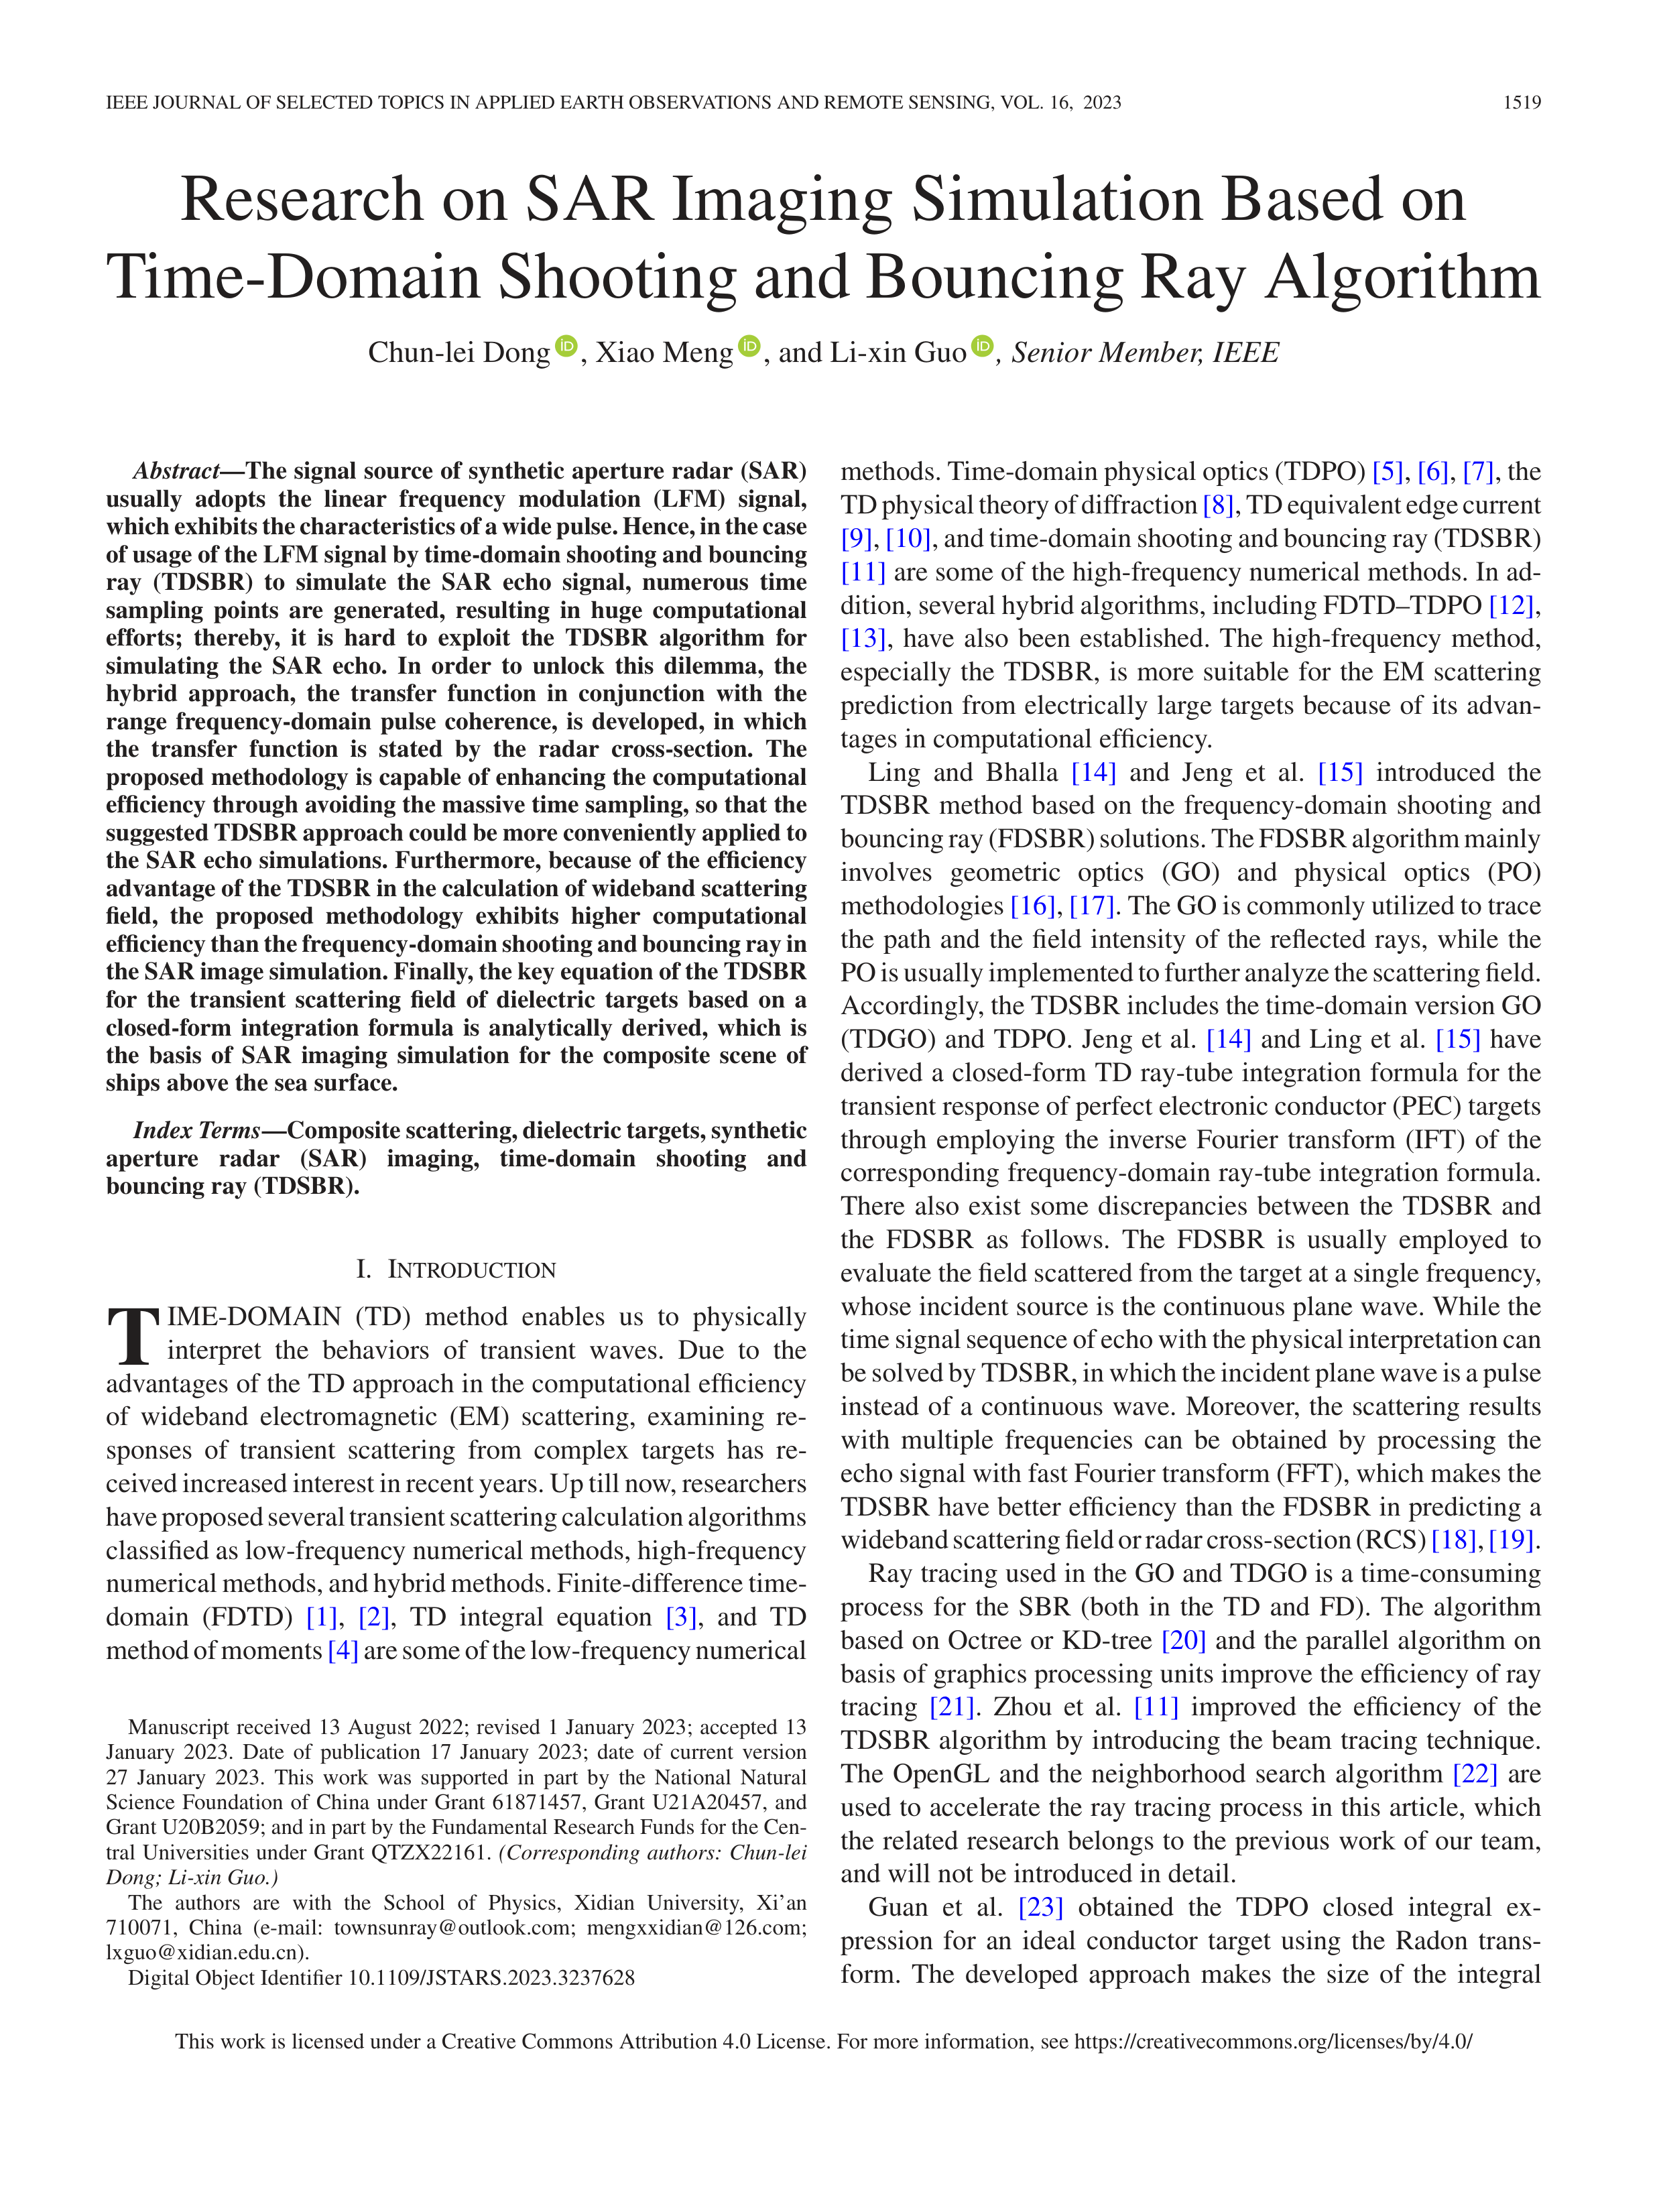

Page 0 image size: (2475, 3300)


In [10]:
# === Annotated for learning ===

doc = load_pdf(PDF_PATH, dpi=300)
print('Loaded PDF:', doc.path.name, '| pages =', doc.num_pages, '| dpi =', doc.dpi)
# Assertion: runtime check to prevent invalid states (page index out of range, image too small, etc.)
assert doc.num_pages > 0, 'Expected at least 1 page'

img0 = page_image(doc, 0)
display(img0)
w, h = img0.size
print('Page 0 image size:', (w, h))
# Assertion: runtime check to prevent invalid states (page index out of range, image too small, etc.)
assert w > 500 and h > 700, 'Rendered image seems too small for 300 dpi'

## 4) Layout extraction on page 0

In [11]:
# === Annotated for learning ===

spans0 = page_layout(doc, 0)
print('spans on page 0:', len(spans0))
print(spans0[:10])
# Assertion: runtime check to prevent invalid states (page index out of range, image too small, etc.)
assert isinstance(spans0, list), 'Expected list of spans'

spans on page 0: 482
[{'text': 'IEEEJOURNALOFSELECTEDTOPICSINAPPLIEDEARTHOBSERVATIONSANDREMOTESENSING,VOL.16,', 'bbox_pdf': (37.908, 33.36251459999994, 384.38381903000925, 40.33631459999992), 'page_index': 0}, {'text': '2023', 'bbox_pdf': (387.878390216983, 33.36251459999994, 401.8197138179044, 40.33631459999992), 'page_index': 0}, {'text': '1519', 'bbox_pdf': (538.0480151648782, 33.36251459999994, 551.9893387657994, 40.33631459999992), 'page_index': 0}, {'text': 'Research', 'bbox_pdf': (64.485, 59.95313509999994, 152.13298671, 83.86343509999995), 'page_index': 0}, {'text': 'on', 'bbox_pdf': (158.09621553, 59.95313509999994, 182.00890656, 83.86343509999995), 'page_index': 0}, {'text': 'SAR', 'bbox_pdf': (187.99126361999998, 59.95313509999994, 234.50157918, 83.86343509999995), 'page_index': 0}, {'text': 'Imaging', 'bbox_pdf': (240.47676315, 59.95313509999994, 320.18413923, 83.86343509999995), 'page_index': 0}, {'text': 'Simulation', 'bbox_pdf': (326.15693217000006, 59.95313509999994, 43

## 5) Coordinate transforms sanity check

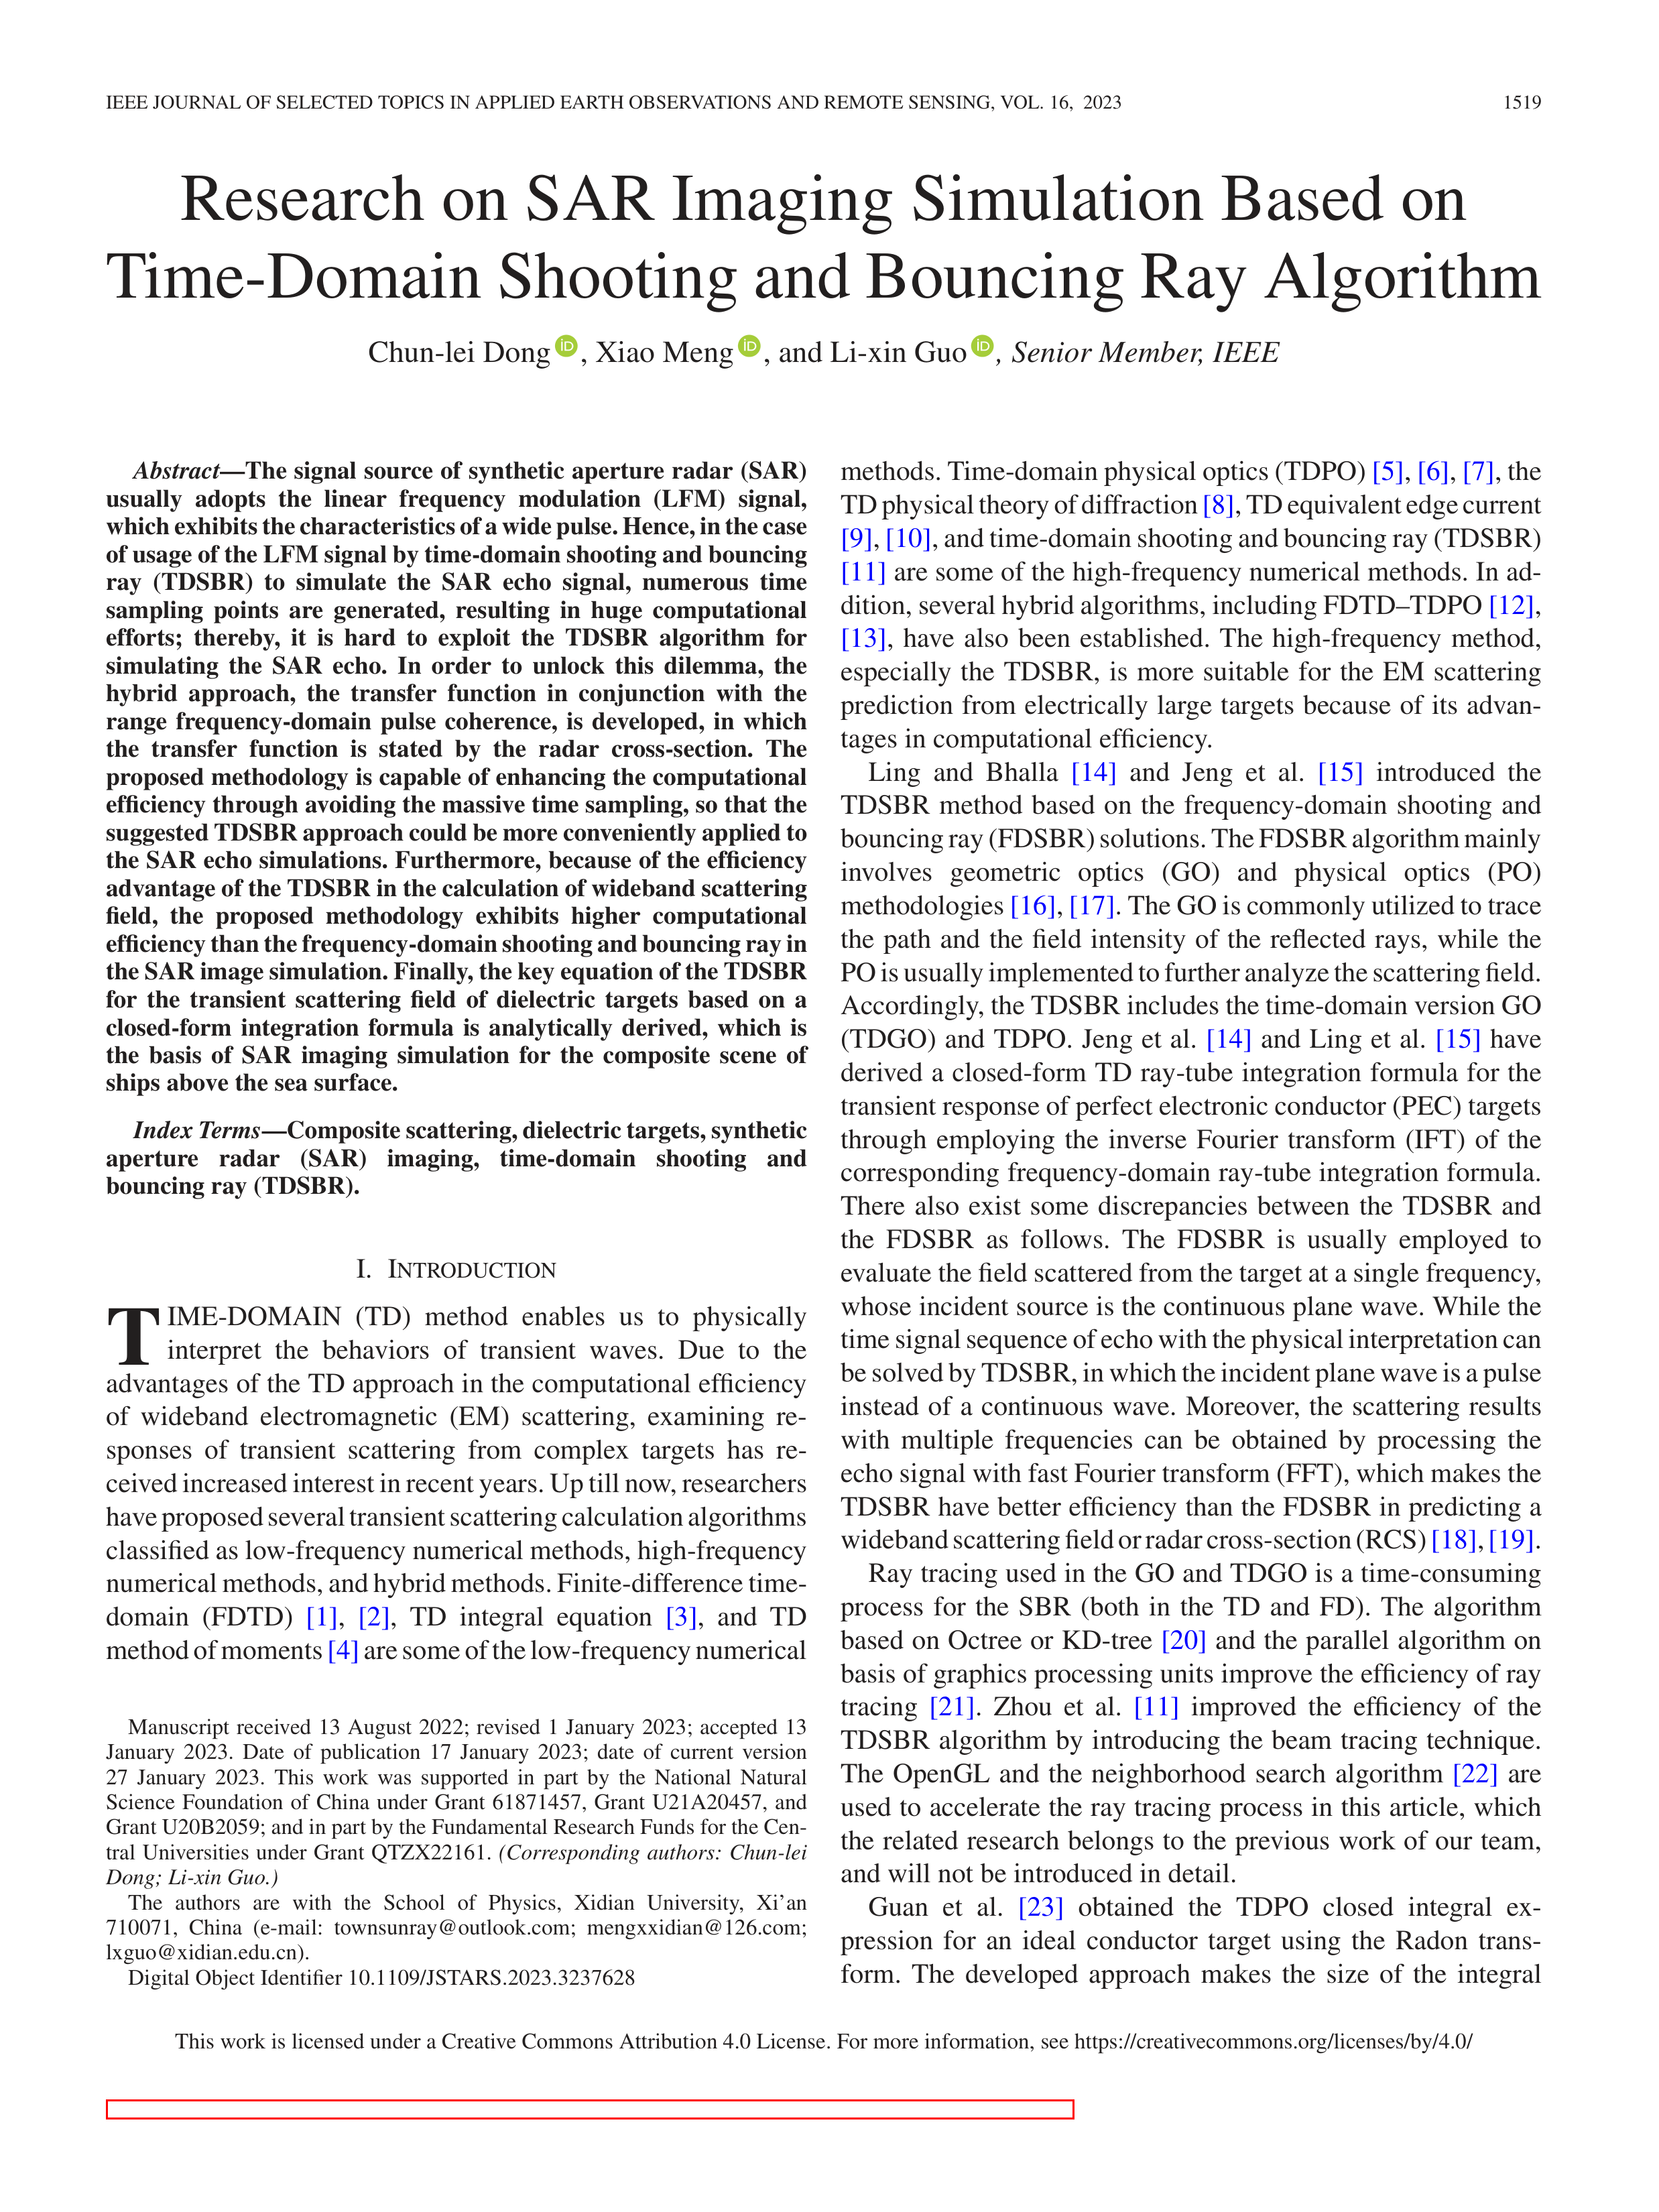

In [12]:
# Import Pillow's drawing helpers to annotate the image
from PIL import ImageDraw

if spans0:
    # --- Pick a demo span: the widest of the first 50 (arbitrary sample) ---
    def span_width(s):
        # Each span has a PDF-space bbox in points (x0, y0, x1, y1), origin bottom-left
        x0, y0, x1, y1 = s["bbox_pdf"]
        return x1 - x0

    span = max(spans0[:50], key=span_width)

    # Unpack the PDF-space bbox (points). Some sources can have x0==x1 or y0==y1;
    # we normalize to ensure x0<x1 and y0<y1 in PDF space first.
    x0_pt, y0_pt, x1_pt, y1_pt = span["bbox_pdf"]
    x0_pt, x1_pt = sorted((x0_pt, x1_pt))  # ensure x0_pt < x1_pt
    y0_pt, y1_pt = sorted((y0_pt, y1_pt))  # ensure y0_pt < y1_pt

    # Get coordinate converters for page 0 at the document DPI
    pdf2px, _ = pdf_to_px_transform(doc, 0)

    # Convert both corners to pixel space (origin top-left, y grows downward)
    x0_px, y0_px = pdf2px(x0_pt, y0_pt)
    x1_px, y1_px = pdf2px(x1_pt, y1_pt)

    # IMPORTANT: after flipping Y, it's common for y0_px > y1_px.
    # Normalize to pixel-space top-left -> bottom-right ordering.
    x_left,  x_right  = sorted((x0_px, x1_px))
    y_top,   y_bottom = sorted((y0_px, y1_px))

    # Guard against degenerate rectangles due to integer rounding:
    # if top==bottom or left==right, expand by 1 pixel to make a visible box.
    if x_left == x_right:
        if x_right < img0.width - 1:
            x_right += 1
        elif x_left > 0:
            x_left -= 1
    if y_top == y_bottom:
        if y_bottom < img0.height - 1:
            y_bottom += 1
        elif y_top > 0:
            y_top -= 1

    # Make a copy to draw on, so img0 stays pristine for other uses
    img = img0.copy()
    draw = ImageDraw.Draw(img)

    # Now we are guaranteed x_left < x_right and y_top < y_bottom
    draw.rectangle([(x_left, y_top), (x_right, y_bottom)], outline="red", width=3)
    display(img)

    # Range + ordering assertions (helpful during dev)
    assert 0 <= x_left  < x_right  <= img.width,  "X coords out of bounds or not ordered"
    assert 0 <= y_top   < y_bottom <= img.height, "Y coords out of bounds or not ordered"

else:
    print("No spans found (likely a scanned PDF) — transform demo skipped.")


## 6) Rendering multiple pages (quick visual pass)

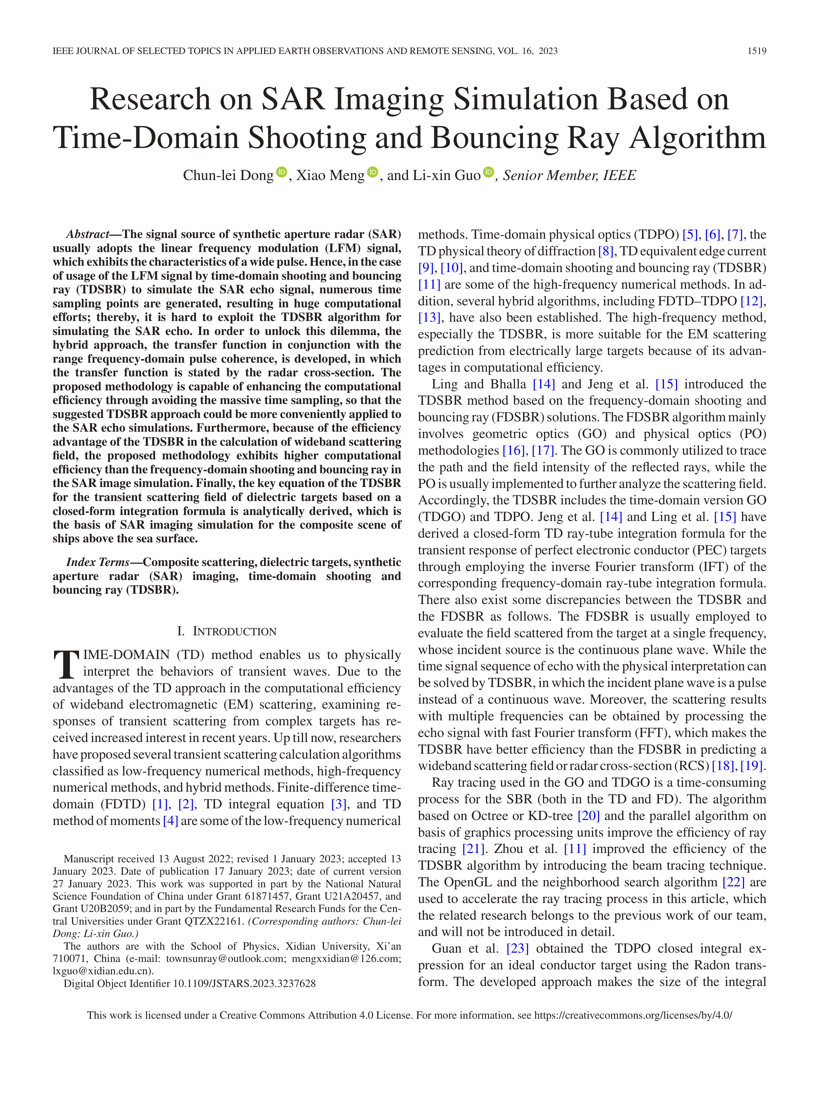

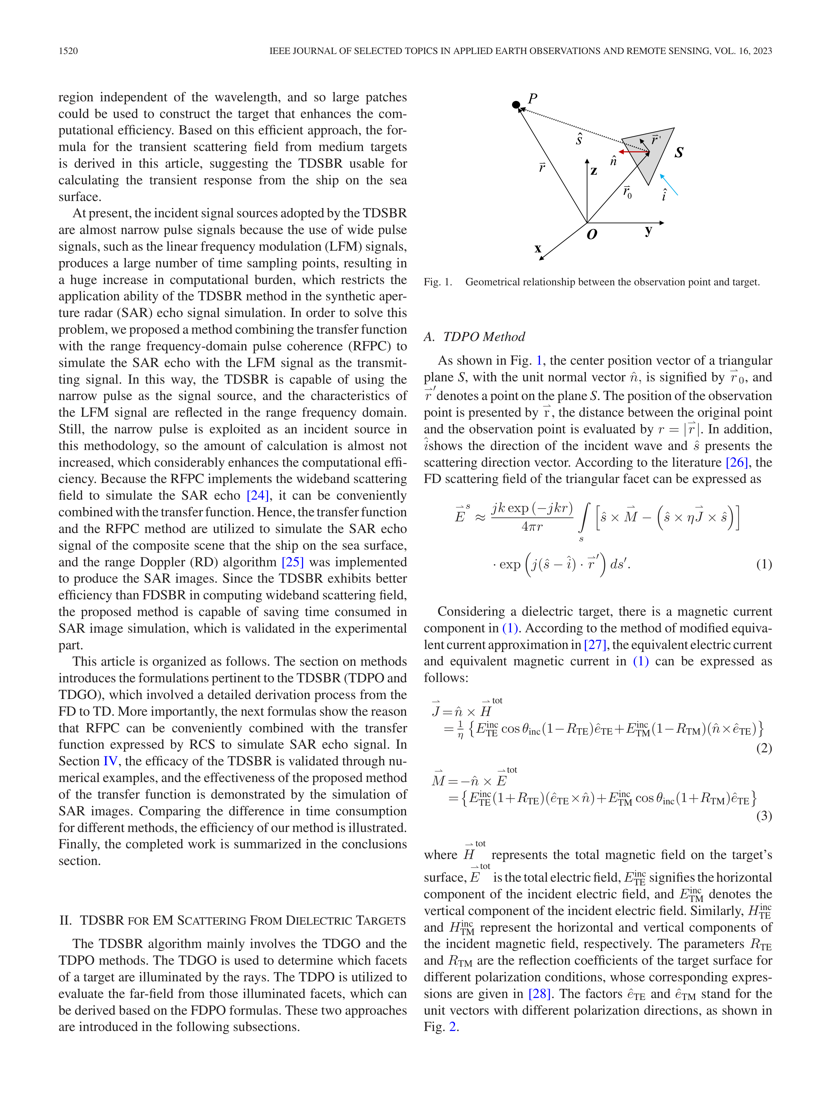

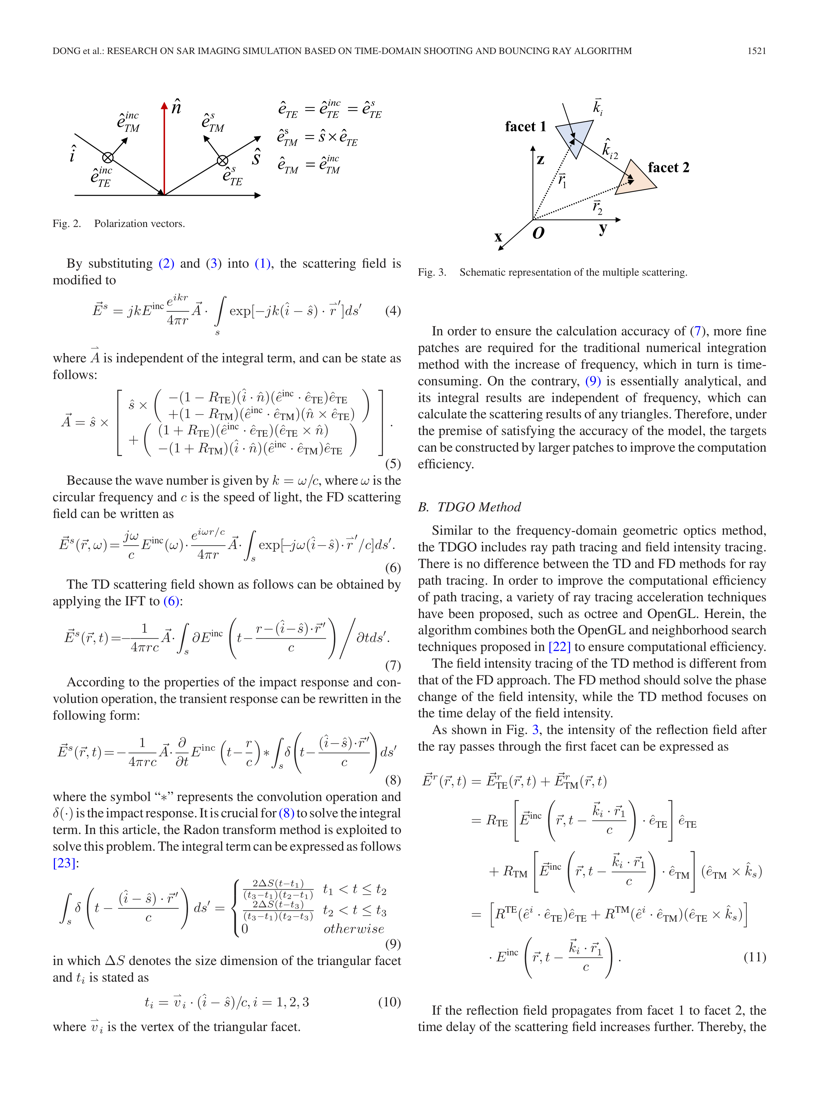

Rendered 3 pages at 300 dpi.


In [13]:
# === Annotated for learning ===

N = min(3, doc.num_pages)
thumbs = []
for i in range(N):
    img = page_image(doc, i)
    thumbs.append(img.resize((img.width//3, img.height//3)))
display(*thumbs)
print(f'Rendered {N} pages at {doc.dpi} dpi.')

## 7) (Optional) Save rendered pages to disk

In [14]:
# === Annotated for learning ===

# Import Path for easier filesystem path handling
from pathlib import Path
out_dir = Path('outputs/pages')
out_dir.mkdir(parents=True, exist_ok=True)

for i in range(min(5, doc.num_pages)):
    img = page_image(doc, i)
    out_path = out_dir / f'page_{i+1:03d}.png'
    img.save(out_path)
print('Saved up to 5 pages into:', out_dir.resolve())

Saved up to 5 pages into: C:\Data\repos\equation_scribe\notebooks\outputs\pages


## 8) Next steps
- Try different DPIs (150, 200, 300) and compare performance vs. clarity.
- Try a scanned PDF to observe `page_layout` returning an empty list (expected).
- Once comfortable, we’ll lift these functions into `src/pdf_ingest.py` and write `pytest` tests.

In [15]:
import math
import pdfplumber
from collections import Counter

MATH_GLYPHS = set("∑∫∂∇±≈≠≤≥∞√→←×•°≈≃≅≜≡⊂⊃⊆⊇∈∉∪∩∧∨¬⇒⇔⊗⊕…")
# Add ASCII hints often used in math text (not definitive on their own)
ASCII_MATH_HINTS = set("^_=/\\|+*-<>")

GREEK = set("αβγδεζηθικλμνξοπρστυφχψωΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ")

MATH_FONTS_HINTS = ("CM", "CMMI", "CMSY", "STIX", "CambriaMath", "Symbol", "MTExtra", "Euclid")

def math_score_pdfplumber(pdf_path, page_index=0):
    """
    Returns a dict with counts and an overall 'score' indicating how likely
    the page has equations in the text layer.
    """
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[page_index]
        chars = page.chars  # fine-grained characters with positions & fonts
        n_chars = len(chars)

        # If almost no characters exist, likely a scan or image-only page.
        if n_chars == 0:
            return {"n_chars": 0, "n_math": 0, "n_greek": 0, "supsub_runs": 0, "math_fonts_hits": 0, "score": 0.0}

        # Count math-ish characters
        n_math = sum(1 for c in chars if c.get("text") in MATH_GLYPHS or c.get("text") in ASCII_MATH_HINTS)
        n_greek = sum(1 for c in chars if c.get("text") in GREEK)

        # Font hints
        fonts = [c.get("fontname","") for c in chars]
        math_fonts_hits = sum(any(hint in f for hint in MATH_FONTS_HINTS) for f in fonts)

        # Baseline analysis: bucket by 'top' (pdfplumber uses PDF coords: origin at bottom-left)
        # We look for small clusters with smaller 'size' that sit above or below the common baseline (superscripts/subscripts).
        sizes = [float(c.get("size", 0)) for c in chars if c.get("size")]
        common_size = sorted(sizes)[len(sizes)//2] if sizes else 0  # crude median

        # Build a histogram of vertical positions (rounded), to approximate a baseline band
        y_tops = [float(c["top"]) for c in chars]
        # Use a coarse binning to find the densest band (the main text line)
        bin_size = 1.5
        bins = Counter(int(y/bin_size) for y in y_tops)
        main_band_bin, _ = bins.most_common(1)[0]
        main_band_center = main_band_bin * bin_size

        # Sup/sub candidates: smaller than common size and not in the main baseline band
        SUPSUB_Y_TOL = 2.5   # points tolerance around main band
        SUPSUB_SIZE_RATIO = 0.85
        supsub = [
            c for c in chars
            if c.get("size") and float(c["size"]) < SUPSUB_SIZE_RATIO*common_size
               and abs(float(c["top"]) - main_band_center) > SUPSUB_Y_TOL
        ]

        # Count runs of consecutive supsubs (very rough proxy for superscripts/subscripts sequences)
        supsub_runs = 0
        run = 0
        last_idx = None
        for idx, c in enumerate(chars):
            if c in supsub:
                run += 1
                last_idx = idx
            else:
                if run >= 2:
                    supsub_runs += 1
                run = 0
        if run >= 2:
            supsub_runs += 1

        # Heuristic score (0..1-ish): weighted signals
        score = 0.0
        if n_chars:
            score += min(0.4, (n_math + n_greek) / max(50, n_chars) * 0.4)  # more math-like glyphs boosts score
            score += min(0.3, supsub_runs * 0.1)                            # presence of supsub runs
            score += min(0.3, math_fonts_hits / max(50, n_chars) * 0.3)     # mathy fonts

        return {
            "n_chars": n_chars,
            "n_math": n_math,
            "n_greek": n_greek,
            "supsub_runs": supsub_runs,
            "math_fonts_hits": math_fonts_hits,
            "score": round(score, 3),
        }

# Example:
# math_score_pdfplumber("data/sample.pdf", 0)


In [16]:
math_score_pdfplumber(PDF_PATH,0)

{'n_chars': 5184,
 'n_math': 45,
 'n_greek': 0,
 'supsub_runs': 3,
 'math_fonts_hits': 0,
 'score': 0.303}

1) Add a minimal LaTeX → SymPy validator

Paste this into a new cell. It checks common syntax issues, tries to parse with SymPy, and computes a stable hash for deduping.

In [17]:
# # Minimal LaTeX validator with SymPy parsing + canonical hash
# from __future__ import annotations
# import re, hashlib
# from dataclasses import dataclass
# from typing import Optional, List, Tuple

# from sympy import Eq, sympify
# try:
#     from sympy.parsing.latex import parse_latex
#     _HAS_PARSE_LATEX = True
#     _PARSE_ERR = None
# except Exception as e:
#     parse_latex = None
#     _HAS_PARSE_LATEX = False
#     _PARSE_ERR = e
# from sympy import srepr, simplify

# @dataclass
# class ValidationResult:
#     ok: bool
#     errors: List[str]
#     expr: Optional[object]
#     canonical_hash: Optional[str]

# _BRACE_PAIRS = {"{":"}", "(":")", "[":"]"}

# def _balanced_braces(s: str) -> Tuple[bool, str]:
#     """Quick brace balance check (not a full LaTeX parser)."""
#     stack = []
#     for i,ch in enumerate(s):
#         if ch in _BRACE_PAIRS:
#             stack.append(_BRACE_PAIRS[ch])
#         elif ch in _BRACE_PAIRS.values():
#             if not stack or stack.pop() != ch:
#                 return False, f"Unmatched closing '{ch}' at pos {i}"
#     if stack:
#         return False, "Unclosed brace(s) at end"
#     return True, ""

# def _micro_normalize(latex: str) -> str:
#     """Small cleanups that reduce trivial variation but preserve math meaning."""
#     t = latex.strip()
#     # remove \( \), \[ \] wrappers if present
#     t = re.sub(r"^\\\(|\\\)$", "", t)
#     t = re.sub(r"^\\\[|\\\]$", "", t)
#     # collapse multiple spaces
#     t = re.sub(r"\s+", " ", t)
#     return t

# def _canonical_hash_from_expr(expr) -> str:
#     """Hash a canonical textual form of the SymPy expression."""
#     try:
#         can = srepr(simplify(expr))
#     except Exception:
#         can = srepr(expr)
#     h = hashlib.sha256(can.encode("utf-8")).hexdigest()
#     return h[:16]  # short id is fine for local deduping

# def validate_latex(latex: str) -> ValidationResult:
#     """Validate LaTeX, try to parse to SymPy, return canonical hash if successful."""
#     errs = []
#     if not latex or not latex.strip():
#         return ValidationResult(False, ["Empty LaTeX"], None, None)

#     s = _micro_normalize(latex)

#     # Fast sanity checks
#     ok, msg = _balanced_braces(s)
#     if not ok:
#         errs.append(f"Brace check: {msg}")

#     # Some common LaTeX mistakes worth surfacing early
#     if "\\left" in s and "\\right" not in s:
#         errs.append("Has \\left but missing matching \\right")
#     if "\\right" in s and "\\left" not in s:
#         errs.append("Has \\right but missing matching \\left")

#     if errs:
#         # Still attempt parse; errors remain for user guidance
#         pass

#     expr = None
#     try:
#         expr = parse_latex(s)
#     except Exception as e:
#         errs.append(f"SymPy parse error: {type(e).__name__}: {e}")

#     if expr is None:
#         return ValidationResult(False, errs, None, None)

#     # If parsing succeeded, compute a canonical hash
#     chash = _canonical_hash_from_expr(expr)
#     return ValidationResult(len(errs)==0, errs, expr, chash)


2) Quick notebook “unit tests” for the validator

Add another cell:

In [18]:
import importlib.util
spec = importlib.util.find_spec("antlr4")
print("antlr4 found:", spec is not None)
if spec:
    import antlr4
    print("ANTLR runtime version:", getattr(antlr4, "__version__", "unknown"))

antlr4 found: True
ANTLR runtime version: unknown


In [19]:
from sympy.parsing.latex import parse_latex

In [20]:
# It seems that the LaTeX parser is a little fussy for which version to use. Until I learn anything different, I'm using v 4.11 of antlr4-python3-runtime, which is the backend LaTeX parser. This is a smoke test letting me know if things are working or not.
def test_sympy_latex_parse_smoke():
    from sympy.parsing.latex import parse_latex
    expr = parse_latex(r"\nabla\cdot \mathbf{E} = \rho/\varepsilon_0")
    assert expr is not None


In [21]:
tests = [
    r"\nabla\cdot \mathbf{E} = \rho/\varepsilon_0",
    r"\frac{a+b}{c} = d",
    r"\left( x + y \right)^2",          # ok
    r"\left( x + y \right.",            # bad: right.
    r"\int_0^\infty e^{-kx} \, dx = 1/k",
    r"",                                # empty
]

for t in tests:
    res = validate_latex(t)
    print("LATEX:", t)
    print("  ok:", res.ok)
    print("  errors:", res.errors)
    print("  expr:", res.expr)
    print("  hash:", res.canonical_hash)
    print("-"*60)


LATEX: \nabla\cdot \mathbf{E} = \rho/\varepsilon_0
  ok: True
  errors: []
  expr: Eq(nabla*(E*mathbf), rho/varepsilon_{0})
  hash: 8935592c72d61431
------------------------------------------------------------
LATEX: \frac{a+b}{c} = d
  ok: True
  errors: []
  expr: Eq((a + b)/c, d)
  hash: ab4e2934283eb7e4
------------------------------------------------------------
LATEX: \left( x + y \right)^2
  ok: True
  errors: []
  expr: (x + y)**2
  hash: 09fe52d034b262f7
------------------------------------------------------------
LATEX: \left( x + y \right.
  ok: False
  errors: ['Brace check: Unclosed brace(s) at end', "SymPy parse error: LaTeXParsingError: I expected one of these: ')'\n\\left( x + y \\right.\n~~~~~~~~~~~~~~~~~~~^"]
  expr: None
  hash: None
------------------------------------------------------------
LATEX: \int_0^\infty e^{-kx} \, dx = 1/k
  ok: True
  errors: []
  expr: Eq(Integral(e**(-k*x), (x, 0, oo)), 1/k)
  hash: 76e71f215554c81c
-------------------------------------